In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

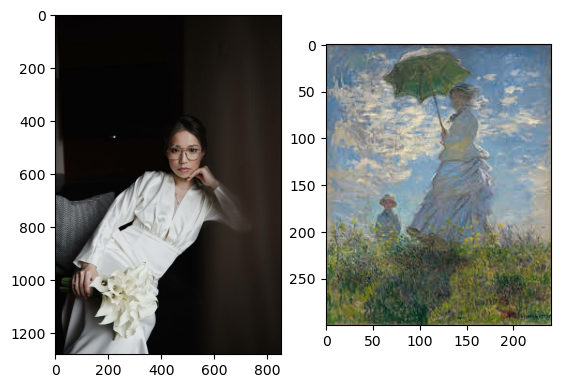

In [2]:
img = tf.io.read_file('ira.jpg')
img = tf.image.decode_jpeg(img)
# img = tf.image.resize_with_crop_or_pad(img, 224, 224)

img_style = tf.io.read_file('mone.jpeg')
img_style = tf.image.decode_jpeg(img_style)
# img_style = tf.image.resize_with_crop_or_pad(img_style, 224, 224)

plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()

# В VGG специфическое распределение цветовых каналов, поэтому надо преодбработать картинки
x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

In [3]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [4]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

In [5]:
model = keras.models.Model(vgg.input, model_outputs)
for layer in model.layers:
    layer.trainable = False

In [6]:
def deprocess_img(processed_img):
    final_img = processed_img.copy()
    
    if len(final_img.shape) == 4:
        final_img = np.squeeze(final_img, 0)
    
    # Возвращаем сдвиг
    final_img[:, :, 0] += 103.939
    final_img[:, :, 1] += 116.779
    final_img[:, :, 2] += 123.68
    
    # Меняем каналы R и B местами
    final_img = final_img[:, :, ::-1]

    final_img = np.clip(final_img, 0, 255).astype('uint8')
    return final_img


def get_feature_representations(model):
    
    # Получаем все выходы с сетки для изначальной картинки и картинки со стилем 
    style_outputs = model(x_style)
    content_outputs = model(x_img)

    # Из картинки со стилем оставляем первые 5 для оценки стилист лосса
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    # Из изначальной картинки оставялем только последний выход, который является выходом для лосса контента
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    return style_features, content_features


def get_my_loss(base, target):
    
    return tf.reduce_mean(tf.square(base - target))


def gram_matrix(input_tensor):
    
    # Функция для создании матрицы грамма (переводим в 2D формат заодно)
    # Определяем количество каналов на поступающем стилистическом выходе
    channels = int(input_tensor.shape[-1])
    # Решейпим
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    # Перемножаем полученную матрицу на транспонированную
    gram = tf.matmul(a, a, transpose_a=True)

    return gram / tf.cast(n, tf.float32)


def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    
    # Общий лосс состоит из двуз компонентов: стилистического и контентного
    # Контентный отвечает за восстановление изначальной картинки, объектов на ней и вообще ее структуры
    # Cтилистический смотрит на качество переноса стиля. Общий - сумма
    
    style_weight, content_weight = loss_weights

    # Получаем все выходы с сетки: 5 для рассчета стилистического лосса и 1 для контентного
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Рассчитываем стилистический лосс, причем считаем, что все выходы со стил слоев вносят одинаковый вклад
    # Заранее также делаем матрицы грамма
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_my_loss(gram_matrix(comb_style[0]), target_style)

    # Рассчитываем контентный лосс 
    content_score += get_my_loss(content_features[0], content_output_features)   
    
    # Домножаем на коэффициенты важности
    style_score *= style_weight
    content_score *= content_weight

    # Возвращаем итоговый лосс
    return style_score + content_score 

In [7]:
num_iterations=200

# Задаем эти коэффициенты для определения того, что нам больше важно для рассчета лосса
content_weight=1e3
style_weight=1e-2

# Определяем таргетные выходные слои для оценки лосса в будущем
style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)

best_loss, best_img = float('inf'), None
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means

In [8]:
for i in range(1, num_iterations + 1): # для каждой интерации рассчитыаем общий лосс
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(model=model, 
                                loss_weights=(style_weight, content_weight), 
                                init_image=init_image, 
                                gram_style_features=gram_style_features, 
                                content_features=content_features)
    
    loss = all_loss # на основании BP рассчитываем градиенты
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)]) # меняем первоначальную картинку на основании градиентов
    clipped = tf.clip_by_value(init_image, min_vals, max_vals) 
    init_image.assign(clipped) # Обрезаем тензор картинки, если вышла за рамки
    
    if i % 10 == 0 or i == 1:
        print(f'Iteration: {i}')
    
    if loss < best_loss:
        # Обновояем лучший лосс (самый меньший) и лучший перенос стиля 
        best_loss = loss
        best_img = deprocess_img(init_image.numpy()) # возвращаем картинку в нормальный формат из формата VGG

Iteration: 1
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200


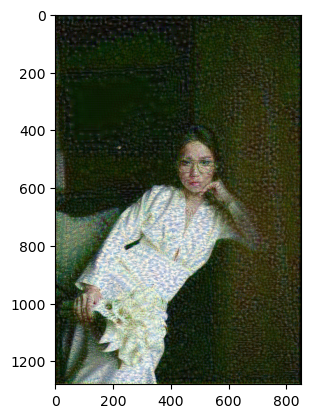

In [9]:
plt.imshow(best_img)

In [13]:
import matplotlib.image

matplotlib.image.imsave('new.png', best_img)